In [1]:
!pip install scikit-build
!pip install pyikarus  --no-build-isolation --verbose --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 2.3 MB/s eta 0:00:00
Using pip 23.0.1 from /dune/dune-common/build-cmake/dune-env/lib/python3.10/site-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 12.7 MB/s eta 0:00:0000:01
  Preparing metadata (pyproject.toml) ...   Running command Preparing metadata (pyproject.toml)
  Note: dune-common will get version requirement (<= 2.9.0) in pyproject.toml as stated in Python-Requires.
  Note: dune-grid will get version requirement (<= 2.9.0) in pyproject.toml as stated in Python-Requires.
  Note: dune-geometry will get version requirement (<= 2.9.0) in pyproject.toml as stated in Python-Requires.
  Note: dune-istl will get version requirement (<= 2.9.0) in pyproject.toml as stated in Python-Requires.
  running dist_info
  creating /tmp/pip-modern-metadata-49hrfydv/pyikarus.egg-info
  writing /tmp/pip-modern-metadata-49hrfydv/pyikarus.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-modern-

### Import all packages

In [2]:
import matplotlib
import dune.grid
import dune.functions
import pyikarus as iks
import pyikarus.finite_elements
import pyikarus.utils
import pyikarus.assembler
import pyikarus.dirichletValues
import numpy as np
import scipy as sp
from dune.vtk import  vtkWriter

DUNE-INFO: Registered external module pyikarus


### Create grid

DUNE-INFO: Generating dune-py module in /dune/dune-common/build-cmake/dune-env/.cache/dune-py
DUNE-INFO: Compiling yasp coordinates dim=2 ctype=double (new)
DUNE-INFO: Compiling HierarchicalGrid (new)
DUNE-INFO: Compiling ReferenceElements (new)
DUNE-INFO: Compiling ReferenceElements (new)
DUNE-INFO: Compiling ReferenceElements (new)
DUNE-INFO: generated new fontManager


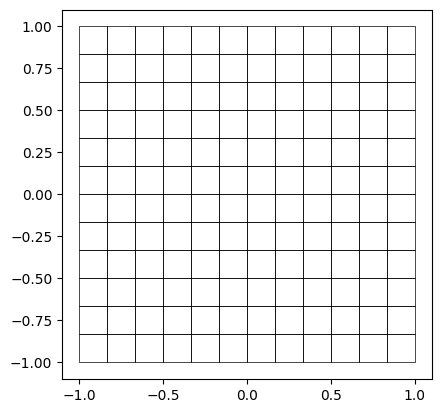

In [3]:
lowerLeft = [-1,-1]
upperRight = [1,1]
elements = [3,3]

grid = dune.grid.structuredGrid(lowerLeft,upperRight,elements)
grid.hierarchicalGrid.globalRefine(2)
grid.plot()

### Add Lagrangian basis

In [49]:
basisLagrange1 = dune.functions.defaultGlobalBasis(grid, dune.functions.Power(dune.functions.Lagrange(order=2),2))
print('We have {} dofs.'.format(len(basisLagrange1)))
print('We have {} vertices.'.format(grid.size(2)))
print('We have {} elements.'.format(grid.size(0)))

We have 1250 dofs.
We have 169 vertices.
We have 144 elements.


### Init load factor and displacement vector

In [50]:
d = np.zeros(len(basisLagrange1))
lambdaLoad = iks.ValueWrapper(.1)

### Create finite element requirements

In [51]:
req= iks.FErequirements()
req.addAffordance(iks.ScalarAffordances.mechanicalPotentialEnergy)
req.addAffordance(iks.VectorAffordances.forces)
req.addAffordance(iks.MatrixAffordances.stiffness)

req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
req.insertGlobalSolution(iks.FESolutions.displacement,d)

### Define volume load and boundary loads

In [52]:
def volumeLoad(x,lambdaVal) :
    return np.array([lambdaVal*x[0]*2*0, 2*lambdaVal*x[1]*0])

def neumannLoad(x,lambdaVal) :
    return np.array([lambdaVal*100, lambdaVal])

neumannVertices = np.zeros(len(basisLagrange1), dtype=bool)
basisLagrange1.interpolate(neumannVertices, lambda x :  True  if x[1]==1 else False)

boundaryPatch = iks.utils.boundaryPatch(grid,neumannVertices)

### Create vector of finite elements

In [53]:
fes = []
for e in grid.elements:
    fes.append(iks.finite_elements.linearElasticElement(basisLagrange1,e,1000,0.2,volumeLoad,boundaryPatch,neumannLoad))


### print forces and stiffness of first element

In [54]:
forces = np.zeros(18)
stiffness = np.zeros((18,18))
fes[1].calculateVector(req,forces)
fes[1].calculateMatrix(req,stiffness)
np.set_printoptions(precision=3)
print('Forces:\n {}'.format(forces))
print('Stiffness:\n {}'.format(stiffness))
print('Eigenvalues: ',np.real(sp.linalg.eigvals(stiffness)))

Forces:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Stiffness:
 [[ 4.537e+02  1.563e+02 -3.056e+02 -6.944e+01  1.389e+01  1.736e+01
   1.389e+01  6.944e+01 -2.593e+02 -2.778e+02  6.019e+01  6.944e+01
  -6.250e+01 -1.736e+01  1.019e+02  6.944e+01 -1.620e+01 -1.736e+01]
 [ 1.563e+02  4.537e+02  6.944e+01  1.389e+01 -1.736e+01 -6.250e+01
  -6.944e+01 -3.056e+02 -2.778e+02 -2.593e+02  6.944e+01  1.019e+02
   1.736e+01  1.389e+01  6.944e+01  6.019e+01 -1.736e+01 -1.620e+01]
 [-3.056e+02  6.944e+01  1.259e+03  0.000e+00 -3.056e+02 -6.944e+01
  -2.593e+02  2.778e+02 -2.222e+02 -7.105e-15 -2.593e+02 -2.778e+02
   1.019e+02 -6.944e+01 -1.111e+02  2.220e-16  1.019e+02  6.944e+01]
 [-6.944e+01  1.389e+01  0.000e+00  1.593e+03  6.944e+01  1.389e+01
   2.778e+02 -2.593e+02  0.000e+00 -1.333e+03 -2.778e+02 -2.593e+02
  -6.944e+01  6.019e+01  0.000e+00  1.111e+02  6.944e+01  6.019e+01]
 [ 1.389e+01 -1.736e+01 -3.056e+02  6.944e+01  4.537e+02 -1.563e+02
   6.019e+01 -6.944e+01 -2.593e+02 

### Create Dirichlet boundary conditions

In [55]:
dirichletValues = iks.dirichletValues(basisLagrange1) 

def fixBottomEdge(vec,localIndex,localView,intersection):
    if (intersection.geometry.center[1]==-1):
        vec[localView.index(localIndex)]= True

dirichletValues.fixBoundaryDOFsUsingLocalViewAndIntersection(fixBottomEdge)

### Create assembler

In [56]:
assembler = iks.assembler.sparseFlatAssembler(fes,dirichletValues)
#assemblerDense = iks.assembler.denseFlatAssembler(fes,dirichletValues)

Msparse = assembler.getMatrix(req)
forces = assembler.getVector(req)
#print(Msparse)
#print(forces)

### Solve for displacements and write to paraview

In [57]:
d = sp.sparse.linalg.spsolve(Msparse,-forces)
dispFunc = basisLagrange1.asFunction(d)



In [58]:
writer = vtkWriter( grid, "nameTest",  pointData   = {( "displacement",(0,1)):dispFunc})

### Plot here using matplot lib

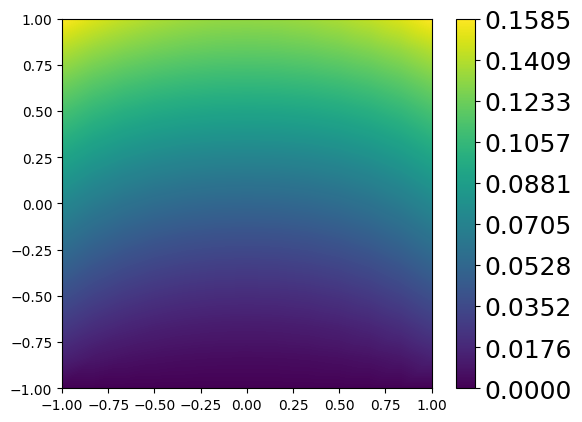

In [59]:
import dune.plotting
dune.plotting.plot(solution=dispFunc,gridLines=None)

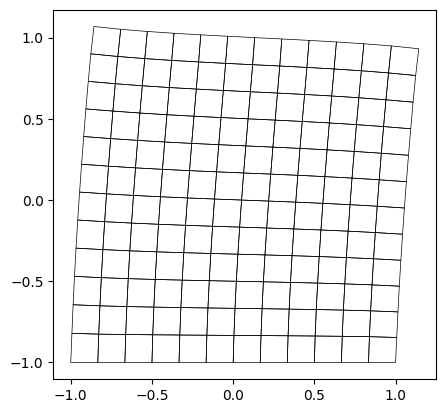

In [60]:
from helper import plotDeformedGrid
plotDeformedGrid(grid,dispFunc) 